# Create MPAS-O and ROMS Histogram Plots for $\zeta$, $\alpha$, $\delta$, and Frontogenesis

In [ ]:
import xarray as xr
import xroms
from xhistogram.xarray import histogram

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.gridspec import GridSpec
import os
import cmocean.cm as cmo
import numpy as np
from numba_celltree import CellTree2d, demo
import time

from bichan_utils import *
from glob import glob
import graphviz
import math

import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
# String legend for plots
res_lgd = ['10 km', '5 km', '2 km', '1 km', '500 m', '200 m', '100 m']

In [ ]:
# Create consistent rainbow-like colormap for different model resolutions

rainbow_cmap = np.asarray([[165,0,38],
                         [215,48,39],
                         [253,174,97],
                         [0,0,0],
                         [171,217,233],
                         [116,173,209],
                         [49,54,149]]) / 255

## Load MPAS-O model outputs

In [ ]:
mroots = [
         '/mpaso_channel/10km/',
         '/mpaso_channel/5km/',
         '/mpaso_channel/2km/',
         '/mpaso_channel/1km/',
         '/mpaso_channel/500m/',    
         '/mpaso_channel/200m/',
         '/mpaso_channel/100m/'
]

In [ ]:
mds = []
mdsg = []
mverts = []
midx = []
mnorm = []

for rootdir in mroots:
    ds_mpas = xr.open_dataset(rootdir + 'output.nc', chunks={'Time': 1})
    dsg = xr.open_dataset(rootdir + 'channel_init.nc')
    ds_mpas['normalizedRelativeVorticity'] = ds_mpas.relativeVorticityCell / dsg.fCell
    ds_mpas['normalizedDivergence'] = ds_mpas.divergence / dsg.fCell
    mds.append(ds_mpas)
    mdsg.append(dsg)

    verts = np.dstack((dsg.xVertex.values[dsg.verticesOnCell-1],
                       dsg.yVertex.values[dsg.verticesOnCell-1]))
    nverts = np.sum(dsg.verticesOnCell != 0, axis=1).values
    verts = [vert[:n] for vert, n in zip(verts, nverts)]
    idx = [(np.abs(vert[:, 0].ptp()) < 50000) for vert in verts]
    midx.append(idx)
    verts = np.array(verts)[idx]
    mverts.append(verts)

    norm = plt.matplotlib.colors.Normalize(-3, 3)
    mnorm.append(norm)

## Load ROMS model outputs

In [ ]:
roms_files = [
         '/roms_channel/10km/roms_his.nc',
         '/roms_channel/5km/roms_his.nc',
         '/roms_channel/2km/roms_his.nc',
         '/roms_channel/1km/roms_his.nc',
         '/roms_channel/500m/roms_his.nc',
         '/roms_channel/200m/roms_his.nc',
         '/roms_channel/100m/roms_his.nc',
        ]


In [ ]:
# Read in ROMS variables and compute vorticity, divergence, other metrics from bichan_utils.py

rdss = []
for file in roms_files:
    ds = xr.open_dataset(file, chunks={'ocean_time': 1})
    ds, xgrid = xroms.roms_dataset(ds)
    ds = add_derivatives_KH(ds, xgrid)
    ds = ds.isel(s_rho=-1)
    rdss.append(ds)

#### Calculate relative vorticity histograms for MPAS-O

In [ ]:
# Time indices of 5-day maximum KE period
t1 = 11*12
t2 = 16*12

bins = np.linspace(-5, 5, 201)

mhss = []
for i in range(len(mds)):
    ympas = mdsg[i].yCell.values
    idx = np.where(np.logical_and(ympas>50e3, ympas<250e3))
    dAmx = mdsg[i].areaCell[idx[0][0]:idx[0][-1]]

    hsx = histogram(mds[i].normalizedRelativeVorticity.isel(
                        Time=slice(t1, t2),
                        nCells=slice(idx[0][0],idx[0][-1]),
                        nVertLevels=0),
                        weights=dAmx, bins=[bins,]).compute()    
    mhss.append(hsx)

#### Calculate relative vorticity histograms for ROMS

In [ ]:
# Time indices of 5-day maximum KE period
t1 = 8*12
t2 = 13*12
tslice = {'ocean_time': slice(t1, t2)}

bins = np.linspace(-5, 5, 201)

rhss = []

for ds in rdss:
    conditional = (ds.y_rho > 50e3) & (ds.y_rho < 250e3)
    dA = 1.0/(ds.pn*ds.pm).where(conditional)   
    if dA.ndim>2:
        dA = dA.isel(ocean_time=0)
        
    hs1 = histogram(ds.zeta.isel(tslice).where(conditional),
                    weights=dA, bins=[bins,]).compute()
    rhss.append(hs1)
 

#### Calculate divergence histograms for MPAS-O

In [ ]:
# Time indices of 5-day maximum KE period
t1 = 11*12
t2 = 16*12

bins = np.linspace(-5, 5, 201)

mhds = []
for i in range(len(mds)):
    ympas = mdsg[i].yCell.values
    # Only calculate divergence where zeta > 1
    conditional = (mds[i].normalizedRelativeVorticity.isel(
                nVertLevels=0, Time=slice(t1,t2)) > 1.0) & (ympas > 50e3) & (ympas < 250e3)
    dAmx = mdsg[i].areaCell

    hsx = histogram(mds[i].normalizedDivergence.isel(
                        Time=slice(t1, t2),
                        nVertLevels=0).where(conditional),
                        weights=dAmx, bins=[bins,]).compute()
    mhds.append(hsx)

#### Calculate divergence histograms for ROMS

In [ ]:
# Time indices of 5-day maximum KE period
t1 = 8*12
t2 = 13*12
tslice = {'ocean_time': slice(t1, t2)}

bins = np.linspace(-5, 5, 201)

rhds = []

for ds in rdss:
    dxs = 1.0/ds.pn[0,0].values
    yslice = [50e3/dxs, 250e3/dxs]
    yslice = list(map(int, yslice))
    # Only calculate divergence where zeta > 1
    conditional = (ds.zeta.isel(eta_rho=slice(yslice[0], yslice[1]), ocean_time=slice(t1, t2)) > 1.0)
    dA = 1.0/(ds.pn*ds.pm).where(conditional)
    hs1 = histogram(ds.delta.isel(tslice).where(conditional), weights=dA, bins=[bins,]).compute()

    rhds.append(hs1)


##### Select bins for plotting and calculating fraction of strongly divergent/convergent flow


In [6]:
bins = np.linspace(-5, 5, 201)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

bin_coords = moving_average(bins, 2)

In [7]:
# Indices for strongly convergent/divergent flow
idx_neg = np.where(bins==-1)[0].item()
idx_pos = np.where(bins==1)[0].item()

In [8]:
# Fraction of divergent flow > |1| in MPAS-O
mneg_frac = []
mpos_frac = []

for ii in range(len(mhds)):
    hdx = mhds[ii,:]
    nvals = hdx[0:idx_neg]
    pvals = hdx[idx_pos::]
    mneg_frac.append(np.sum(nvals)/np.sum(hdx))
    mpos_frac.append(np.sum(pvals)/np.sum(hdx))

In [23]:
# Fraction of divergent flow > |1| in ROMS

rneg_frac = []
rpos_frac = []

for ii in range(len(rhds)):
    hdx = rhds[ii,:]
    nvals = hdx[0:idx_neg]
    pvals = hdx[idx_pos::]
    rneg_frac.append(np.sum(nvals)/np.sum(hdx))
    rpos_frac.append(np.sum(pvals)/np.sum(hdx))

##### Example plot of ROMS and MPAS-O relative vorticity histograms for 1 km spatial resolution

Text(0.5, 0, 'Normalized Relative Vorticity, ($\\zeta/f$)')

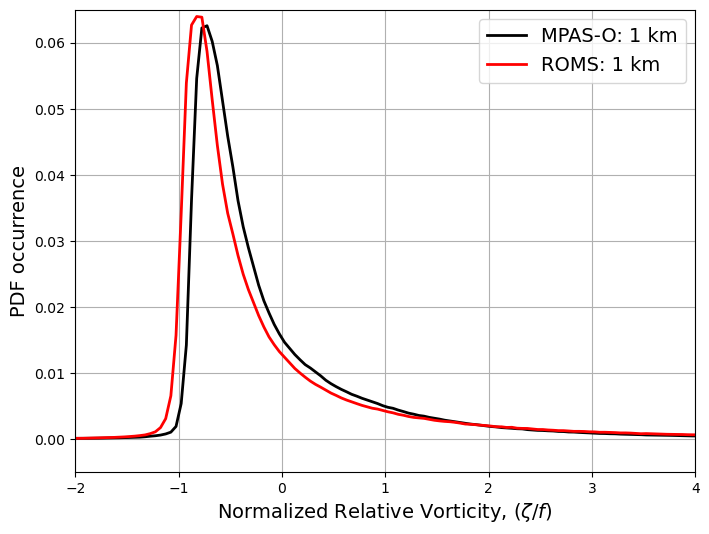

In [28]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

icolor = 0

hsplot = mhss[4] / np.sum(mhss[4])
ax.plot(bin_coords, hsplot, color='k', linewidth=2, label='MPAS-O: 1 km')
hsplot = rhss[4] / np.sum(rhss[4])
ax.plot(bin_coords, hsplot, color='r', linewidth=2, label='ROMS: 1 km')

ax.set_xlim(-2, 4)
ax.set_ylim(-0.005, 0.065)
ax.grid(True)
ax.legend(loc='best', fontsize=14)
ax.set_ylabel('PDF occurrence', fontsize=14)
ax.set_xlabel(r'Normalized Relative Vorticity, ($\zeta/f$)', fontsize=14)

### Create combined Figure 6 plot

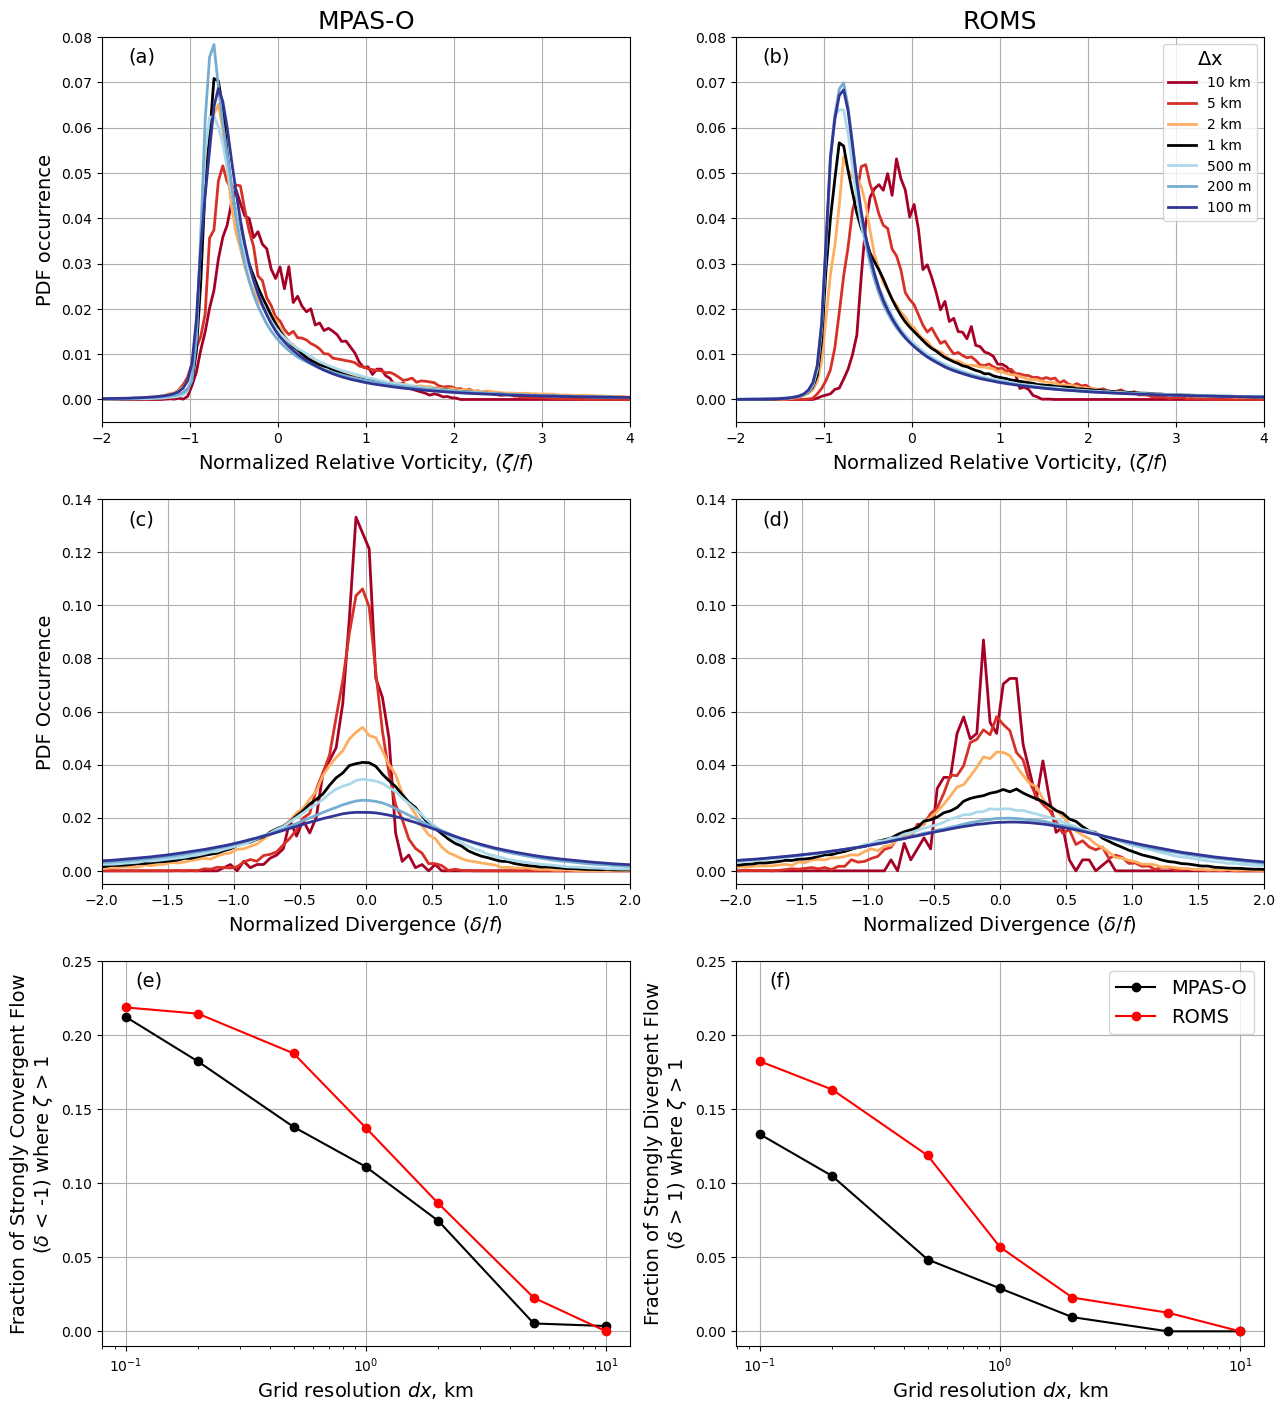

In [27]:
fig, axs = plt.subplots(3, 2, figsize=(15, 17))

# Resolution array for panels e and f
res_dx = [10, 5, 2, 1, 0.5, 0.2, 0.1]

# MPAS Vorticity
ax = axs[0,0]
icolor = 0
for i in range(len(mhss)):
    hsplot = mhss[i] / np.sum(mhss[i])
    ax.plot(bin_coords, hsplot, color=rainbow_cmap[i,:], linewidth=2)
    
ax.set_xlim(-2, 4)
ax.set_ylim(-0.005, 0.08)
ax.grid(True)
ax.set_ylabel('PDF occurrence', fontsize=14)
ax.set_xlabel(r'Normalized Relative Vorticity, ($\zeta/f$)', fontsize=14)
ax.set_title('MPAS-O', fontsize=18)
ax.text(-1.7, 0.0745, '(a)', fontsize=14)

# MPAS Divergence
ax = axs[1,0]
icolor = 0
for i in range(len(mhds)):
    hsplot = mhds[i] / np.sum(mhds[i])
    ax.plot(bin_coords, hsplot, color=rainbow_cmap[i,:], linewidth=2)
    
ax.set_xlim(-2, 2)
ax.set_ylim(-0.005, 0.14)
ax.grid(True)
ax.set_ylabel('PDF Occurrence', fontsize=14)
ax.set_xlabel(r'Normalized Divergence ($\delta/f$)', fontsize=14)
# ax.text(-1.8, 0.127, '(c)', fontsize=14)
ax.text(-1.8, 0.13, '(c)', fontsize=14)

# ROMS Vorticity
ax = axs[0,1]
icolor = 0
for i in range(len(mhss)):
    hsplot = rhss[i] / np.sum(rhss[i])
    ax.plot(bin_coords, hsplot, color=rainbow_cmap[i,:], linewidth=2)
    
ax.set_xlim(-2, 4)
ax.set_ylim(-0.005, 0.08)
ax.grid(True)
l1 = ax.legend(res_lgd, loc='upper right', title='$\Delta$x')
l1.get_title().set_fontsize('14')
ax.set_xlabel(r'Normalized Relative Vorticity, ($\zeta/f$)', fontsize=14)
ax.set_title('ROMS', fontsize=18)
ax.text(-1.7, 0.0745, '(b)', fontsize=14)

# ROMS Divergence
ax = axs[1,1]
icolor = 0
for i in range(len(mhds)):
    hsplot = rhds[i] / np.sum(rhds[i])
    ax.plot(bin_coords, hsplot, color=rainbow_cmap[i,:], linewidth=2)
    
ax.set_xlim(-2, 2)
ax.set_ylim(-0.005, 0.14)
ax.grid(True)
ax.set_xlabel(r'Normalized Divergence ($\delta/f$)', fontsize=14)
ax.text(-1.8, 0.13, '(d)', fontsize=14)

# Fraction of Convergent Flow
ax = axs[2,0]
ax.plot(res_dx, mneg_frac, '-o', label='MPAS-O', color='k')
ax.plot(res_dx, rneg_frac, '-o', label='ROMS', color='r')
ax.set_xlabel(r'Grid resolution $dx$, km', fontsize=14)
ax.set_ylabel('Fraction of Strongly Convergent Flow\n($\delta$ < -1) where $\zeta$ > 1', fontsize=14)
ax.set_xscale('log')
ax.set_ylim(-0.01, 0.25)
ax.grid('both')
ax.text(1.1E-1, 0.233, '(e)', fontsize=14)

# Fraction of Divergent Flow
ax = axs[2,1]
ax.plot(res_dx, mpos_frac, '-o', label='MPAS-O', color='k')
ax.plot(res_dx, rpos_frac, '-o', label='ROMS', color='r')
ax.set_xlabel(r'Grid resolution $dx$, km', fontsize=14)
ax.set_ylabel('Fraction of Strongly Divergent Flow\n($\delta$ > 1) where $\zeta$ > 1', fontsize=14)
ax.set_xscale('log')
ax.set_ylim(-0.01, 0.25)
ax.legend(fontsize=14)
ax.grid('both')
ax.text(1.1E-1, 0.233, '(f)', fontsize=14)



## Calculate Joint PDF histograms for Figures 7-9

#### Calculate total strain and other divergence components from MPAS outputs based on velocity gradients

In [ ]:
# Code modified from bichan_utils.py

mds_vel = []
ictr = 0

for ds in mds:
    ##################################
    # Add Coriolis term to output file for simplicity of below equations
    ds['f'] = np.unique(mdsg[ictr].fCell.values)
    
    ##################################
    # Add strain
    ds['alpha'] = ( np.sqrt( (ds.dUdx_cell-ds.dVdy_cell)**2 + (ds.dVdx_cell+ds.dUdy_cell)**2 ) 
              ) / ds.f.values
    ds['alpha'].name = 'Normalized total strain'
    
    ##################################
    # Principle deformation components

    ds['lminor'] = 0.5 * (ds.normalizedDivergence - ds.alpha)
    ds['lminor'].name = 'lambda minor'

    ds['lmajor'] = 0.5 * (ds.normalizedDivergence + ds.alpha)
    ds['lmajor'].name = 'lambda major'    
    ##################################
    # Along- and cross-frontal velocity gradients
    
    # angle is wrt x, so need to do arctan2(y, x)
    ds['phi_cf'] = np.arctan2(ds.dSdy_cell, ds.dSdx_cell)
    ds['phi_af'] = ds.phi_cf + np.pi/2.0

    ds['du_cf'] = ( ds.dUdx_cell*np.cos(ds.phi_cf)**2 + ds.dVdy_cell*np.sin(ds.phi_cf)**2 
               + (ds.dUdy_cell + ds.dVdx_cell)*np.sin(ds.phi_cf)*np.cos(ds.phi_cf) )/ds.f.values

    ds['du_af'] = ( ds.dUdx_cell*np.cos(ds.phi_af)**2 + ds.dVdy_cell*np.sin(ds.phi_af)**2
              + (ds.dUdy_cell + ds.dVdx_cell)*np.sin(ds.phi_af)*np.cos(ds.phi_af) )/ds.f.values
    
    ##################################
    # The frontogenesis function
    
    # Dimensional frontogenesis function
    Dgradq_i = - ds.dUdx_cell*ds.dSdx_cell - ds.dVdx_cell*ds.dSdy_cell
    Dgradq_j = - ds.dUdy_cell*ds.dSdx_cell - ds.dVdy_cell*ds.dSdy_cell
    ds['Ddelq2'] = (ds.dSdx_cell*Dgradq_i + ds.dSdy_cell*Dgradq_j)
    ds['Ddelq2'].name = 'Frontogenesis function'

    # Density gradients squared
    ds['gradq2'] = ds.dSdx_cell**2 + ds.dSdy_cell**2
    ds['gradq2'].name = r'$(\nabla q)^2$'

    # Normalized frontogenesis function
    ds['nFGF'] = 0.5 * ds.Ddelq2 / (ds.gradq2 * ds.f.values)
    ds['nFGF'].name = r'Normalized Frontogenesis Function'    
    
    ##################################
    ictr+=1
    
    mds_vel.append(ds)

### Compute histograms of strain vs relative vorticity

In [ ]:
#--- MPAS-O ---#

# Select bin ranges for computation
bins = np.linspace(-20, 20, 201)

# Select time indices corresponding to maximum KE over 5-day period
t1 = 11*12
t2 = 16*12

mhavs = []

for axi in range(len(mds)):
    ympas = mdsg[axi].yCell.values
    idx = np.where(np.logical_and(ympas>50e3, ympas<250e3))

    h = histogram(mds_vel[axi].alpha.isel(
                        Time=slice(t1,t2),
                        nCells=slice(idx[0][0],idx[0][-1]),
                        nVertLevels=0),
                   mds_vel[axi].normalizedRelativeVorticity.isel(
                        Time=slice(t1,t2),
                        nCells=slice(idx[0][0], idx[0][-1]),
                        nVertLevels=0), 
                   bins=[bins, bins]).compute()
    mhavs.append(h)

In [ ]:
#--- ROMS ---#

# Select bin ranges for computation
bins = np.linspace(-20, 20, 201)

# Select time indices corresponding to maximum KE over 5-day period
t1 = 8*12
t2 = 13*12
tslice = {'ocean_time': slice(t1, t2)}

rhavs = []

for ds in rdss:
    conditional = (ds.y_rho > 50e3) & (ds.y_rho < 250e3)
    
    h = histogram(ds.alpha.isel(tslice).where(conditional),
                  ds.zeta.isel(tslice).where(conditional), 
                  bins=[bins, bins]).compute()
    rhavs.append(h)

### Compute histograms of divergence vs relative vorticity

In [ ]:
#--- MPAS-O ---#

# Select bin ranges for computation
bins = np.linspace(-20, 20, 201)

# Select time indices corresponding to maximum KE over 5-day period
t1 = 11*12
t2 = 16*12

mhdvs = []

for axi in range(len(mds_vel)):
    ympas = mdsg[axi].yCell.values
    idx = np.where(np.logical_and(ympas>50e3, ympas<250e3))
    
    h = histogram(mds_vel[axi].normalizedDivergence.isel(
                                        Time=slice(t1,t2),
                                        nCells=slice(idx[0][0], idx[0][-1]),
                                        nVertLevels=0),
                  mds_vel[axi].normalizedRelativeVorticity.isel(
                                        Time=slice(t1,t2),
                                        nCells=slice(idx[0][0], idx[0][-1]),
                                        nVertLevels=0),
                  bins=[bins, bins]).compute()
    
    mhdvs.append(h)





In [ ]:
#--- ROMS ---#

# Select bin ranges for computation
bins = np.linspace(-20, 20, 201)

# Select time indices corresponding to maximum KE over 5-day period
t1 = 8*12
t2 = 13*12
tslice = {'ocean_time': slice(t1, t2)}


rhdvs = []
for ds in rdss:
    conditional = (ds.y_rho > 50e3) & (ds.y_rho < 250e3)
    
    h = histogram(ds.delta.isel(tslice).where(conditional),
                  ds.zeta.isel(tslice).where(conditional), 
                  bins=[bins, bins]).compute()
    rhdvs.append(h)

### Figure 7 Plot of $\alpha$ vs $\zeta$

In [ ]:
# Compute bins for plotting

bins = np.linspace(-20, 20, 201)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

bin_coords = moving_average(bins, 2)

In [ ]:
# Select subset of simulations for readability
xvec = [0,0,0,0,1,1,1,1]
yvec = [0,1,2,3,0,1,2,3]

# Model spatial resolutions (m)
dxs = [10e3, 5e3, 2e3, 1e3, 5e2, 2e2, 1e2]

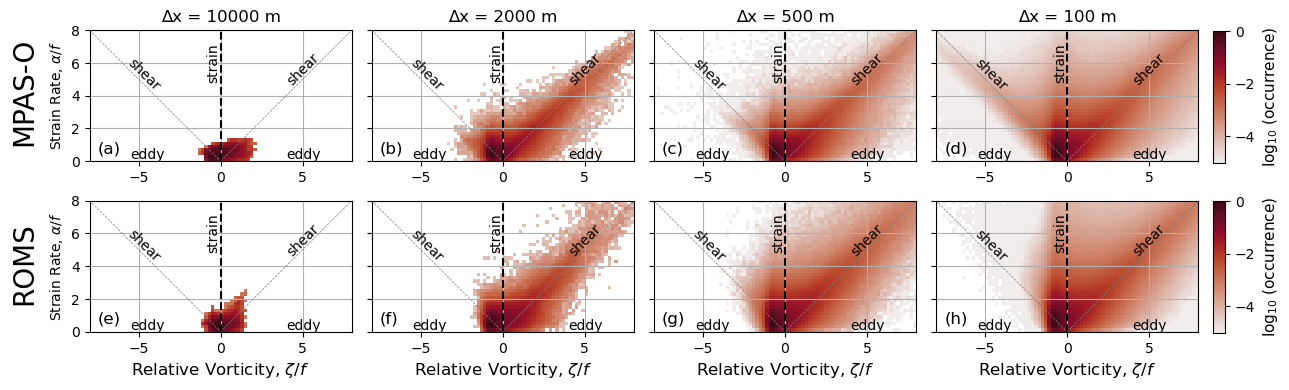

In [51]:
fig = plt.figure(figsize=(12, 4))


gs = GridSpec(2, 4)
kl = [10, 5, 2, 1, 0.5, 0.2, 0.1]

subsel = [0, 2, 4, 6, 0, 2, 4, 6] # Select 4 resolutions for plots
raxi = 0
sublab = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']


for axi in range(len(subsel)):
    if xvec[axi]==0:
        h = mhavs[subsel[axi]]
    elif xvec[axi]==1:
        h = rhavs[subsel[raxi]]
        raxi+=1
    
    ax = fig.add_subplot(gs[xvec[axi], yvec[axi]])
    pc = ax.pcolormesh(bin_coords, bin_coords, np.log10(h/np.max(h)), cmap=cmo.amp)
    pc.set_clim(-5, 0)

    ax.grid(True)
    ax.set_xlim(-8, 8)
    ax.set_ylim(0, 8)
    ax.set_aspect(1.0)
    
    ax.axline((0, 0), slope=1., color='grey', linestyle='--', linewidth=0.5)
    ax.axline((0, 0), slope=-1., color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(color="k", linestyle='--', linewidth=1.5)
    if axi >= 4:
        ax.set_xlabel(r'Relative Vorticity, $\zeta/f$', fontsize=12)
    if axi % 4 > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    else:
        ax.set_ylabel(r'Strain Rate, $\alpha/f$')
        if xvec[axi]==0:
            ax.text(-12.85, 1.3, 'MPAS-O', size=20, rotation=90)
        elif xvec[axi]==1:
            ax.text(-12.85, 2.0, 'ROMS', size=20, rotation=90)
    
    if axi < 4:
        ax.set_title('∆x = %d m' % dxs[subsel[axi]], fontsize=12)
    ax.text(-5.8, 4.3, 'shear', rotation=-45, fontsize=10)
    ax.text(3.9, 4.65, 'shear', rotation=45, fontsize=10)
    ax.text(-0.85, 5, 'strain', rotation=90, fontsize=10)
    ax.text(-5.5, 0.15, 'eddy', fontsize=10)
    ax.text(4, 0.15, 'eddy', fontsize=10)
    ax.text(-7.5, 0.5, '%s' % sublab[axi], fontsize=12)
    
plt.tight_layout()

# Add colorbar for both rows of panels
cax = fig.add_axes([1.0, 0.58, 0.01, 0.33])
cbar = plt.colorbar(pc, cax=cax, aspect=0.2)
cbar.ax.set_ylabel('log$_{10}$ (occurrence)', fontsize=11)

cax = fig.add_axes([1.0, 0.155, 0.01, 0.33])
cbar = plt.colorbar(pc, cax=cax, aspect=0.2)
cbar.ax.set_ylabel('log$_{10}$ (occurrence)', fontsize=11)



### Figure 8 Plot of $\delta$ vs $\zeta$

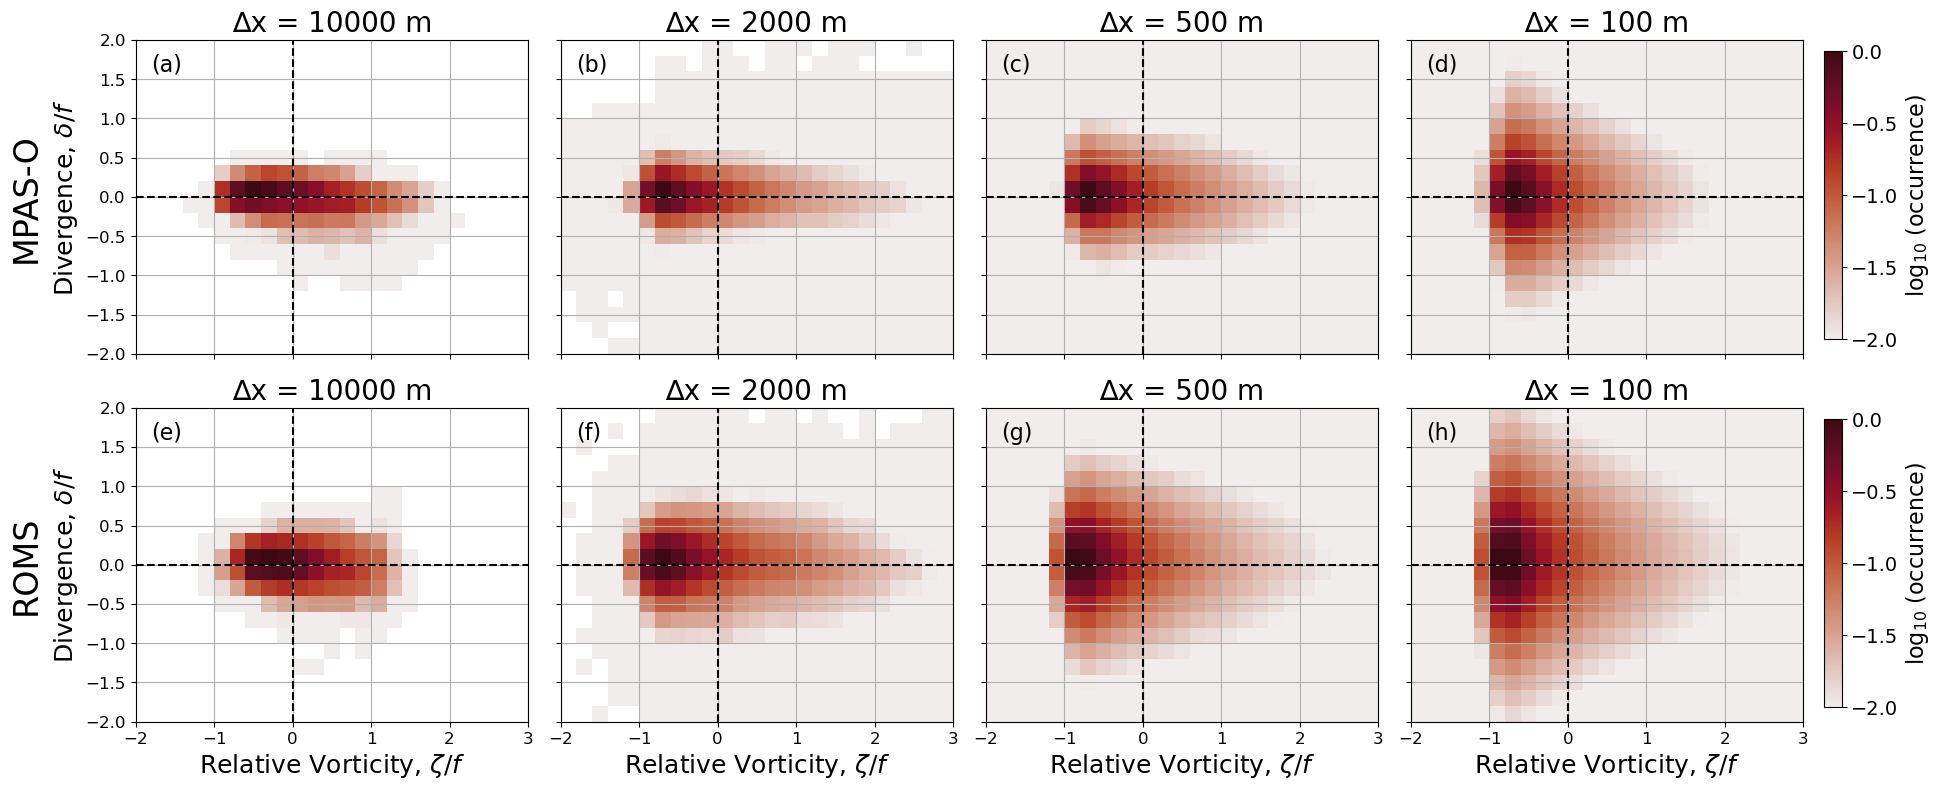

In [56]:
# Divergence vs vorticity plot
fig, axs = plt.subplots(2, 4, figsize=(18, 8))

subsel = [0, 2, 4, 6, 0, 2, 4, 6] # Select 4 resolutions for plots
raxi = 0
sublab = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

for axi in range(len(subsel)):
    
    if xvec[axi]==0:
        h = mhdvs[subsel[axi]]
        ax = axs[xvec[axi],yvec[axi]]

    elif xvec[axi]==1:
        h = rhdvs[subsel[raxi]]
        ax = axs[xvec[axi],yvec[axi]]
        raxi+=1

    pc = ax.pcolormesh(bin_coords, bin_coords, np.log10(h/np.max(h)), cmap=cmo.amp)
    pc.set_clim(-2, 0)


    ax.grid(True)
    ax.set_xlim(-2, 3)
    ax.set_ylim(-2, 2)
    ax.set_aspect(1.0)

    ax.axvline(color="k", linestyle='--', linewidth=1.5)
    ax.axhline(color="k", linestyle='--', linewidth=1.5)
    if xvec[axi]==0:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    elif xvec[axi]==1:
        ax.set_xlabel(r'Relative Vorticity, $\zeta/f$', fontsize=18)
    
    # add subplot label
    ax.text(-1.8, 1.6, '%s' % sublab[axi], size=16)
    
    # modify ticks and ticklabels
    ax.tick_params(axis='both', which='major', labelsize=12)
    if axi % 4 > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    else:
        ax.set_ylabel(r'Divergence, $\delta/f$', fontsize=18)
        if xvec[axi]==0:
            ax.text(-3.6, -0.75, 'MPAS-O', size=24, rotation=90)
        elif xvec[axi]==1:
            ax.text(-3.6, -0.55, 'ROMS', size=24, rotation=90)
            
    ax.set_title('∆x = %d m' % dxs[subsel[axi]], fontsize=20)
    


# Add colorbar for both rows of panels
cax = fig.add_axes([1.0, 0.11, 0.01, 0.36])
cbar = plt.colorbar(pc, cax=cax, aspect=0.2)
cbar.ax.set_ylabel('log$_{10}$ (occurrence)', fontsize=16)
cax.tick_params(axis='y', which='major', labelsize=12)
cbar.ax.tick_params(labelsize=14)

cax = fig.add_axes([1.0, 0.57, 0.01, 0.36])
cbar = plt.colorbar(pc, cax=cax, aspect=0.2)
cbar.ax.set_ylabel('log$_{10}$ (occurrence)', fontsize=16)
cax.tick_params(axis='y', which='major', labelsize=12)
cbar.ax.tick_params(labelsize=14)


plt.tight_layout()


## Calculate metrics for frontogenesis plots (Figure 9)

#### Calculate Distribution and PCA Parameters for MPAS-O

In [ ]:
# Select time indices corresponding to maximum KE over 5-day period
t1 = 11*12
t2 = 16*12

mhpca = []
mes = []
mvs = []
mxos = []
myos = []

xbins = np.linspace(-3, 3, 201)
ybins = np.linspace(-5, 3, 201)

for axi in range(len(mds_vel)):
    ympas = mdsg[axi].yCell.values
    conditional = (mds_vel[axi].normalizedRelativeVorticity.isel(
                    nVertLevels=0, Time=slice(t1,t2)) > 1.0) & (ympas > 50e3) & (ympas < 250e3)
    
    h = histogram(mds_vel[axi].du_cf.isel(Time=slice(t1,t2), nVertLevels=0).where(conditional),
                  mds_vel[axi].du_af.isel(Time=slice(t1,t2), nVertLevels=0).where(conditional), 
                  bins=[ybins, xbins]).compute()
    mhpca.append(h)
    
    # create 2xtimexspace matrix
    X = np.asarray([mds_vel[axi].du_cf.isel(nVertLevels=0, Time=slice(t1,t2)).where(conditional).values,
                    mds_vel[axi].du_af.isel(nVertLevels=0, Time=slice(t1,t2)).where(conditional).values])

    # remove nans and flatten time and spacial dims
    idx = ~np.isnan(X[0])
    X = X[:, idx]

    e, v = np.linalg.eig(np.cov(X-X.mean(axis=1, keepdims=True)))
    es.append(e)
    vs.append(v)
    
    # The distribution mean in x & y
    yo, xo = X.mean(axis=1)
    yos.append(yo)
    xos.append(xo)

    # The major/minor axis of variation, as a vector centered at 0,0
    v_major = [np.sqrt(e[0])*v[1, 0], np.sqrt(e[0])*v[0, 0]]
    v_minor = [np.sqrt(e[1])*v[1, 1], np.sqrt(e[1])*v[0, 1]]

    # The angle of the major axis, relative to the positive y-axis, positive CCW
    # In this case, pi/4 represents straining flow, 0 represents divergent flow
    theta = np.arctan(v[1, 0]/v[0, 0])


#### Calculate Distribution and PCA Parameters for ROMS

In [ ]:
# Select time indices corresponding to maximum KE over 5-day period
t1 = 8*12
t2 = 13*12
tslice = {'ocean_time': slice(t1, t2)}

rhpca = []
res = []
rvs = []
rxos = []
ryos = []
xbins = np.linspace(-3, 3, 201)
ybins = np.linspace(-5, 3, 201)


ictr = 0

for ds in rdss:

    t1 = time.time()    
    conditional = (ds.zeta.isel(tslice) > 1.0) & (ds.y_rho > 50e3) & (ds.y_rho < 250e3)
    h = histogram(ds.du_cf.isel(tslice).where(conditional),
                  ds.du_af.isel(tslice).where(conditional), 
                  bins=[ybins, xbins]).compute()
    rhpca.append(h)

    # create 2xtimexspace matrix
    X = np.asarray([ds.du_cf.isel(tslice).where(conditional).values,
                    ds.du_af.isel(tslice).where(conditional).values])

    # remove nans and flatten time and spatial dims
    idx = ~np.isnan(X[0])
    X = X[:, idx]

    e, v = np.linalg.eig(np.cov(X-X.mean(axis=1, keepdims=True)))
    es.append(e)
    vs.append(v)
    
    # The distribution mean in x & y
    yo, xo = X.mean(axis=1)
    yos.append(yo)
    xos.append(xo)
    
    # The major/minor axis of variation, as a vector centered at 0,0
    v_major = [np.sqrt(e[0])*v[1, 0], np.sqrt(e[0])*v[0, 0]]
    v_minor = [np.sqrt(e[1])*v[1, 1], np.sqrt(e[1])*v[0, 1]]

    # The angle of the major axis, relative to the positive y-axis, positive CCW
    # In this case, pi/4 represents straining flow, 0 represents divergent flow
    theta = np.arctan(v[1, 0]/v[0, 0])


In [58]:
xbins = np.linspace(-3, 3, 201)
ybins = np.linspace(-5, 3, 201)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

xbin_coords = moving_average(xbins, 2)
ybin_coords = moving_average(ybins, 2)

#### Calculate metrics of frontogenesis for values in Table 1

##### MPAS-O metrics

In [63]:
mpas_angle = [] # Phi_PCA column in Table 1
mpas_hyp = []
mpas_hshort = []

for axi in range(len(mhpca)):
# axi = 6
    h = mhpca[axi]
    xo = mxos[axi]
    yo = myos[axi] # <du/dx> column in Table 1
    e = mes[axi]
    v = mvs[axi]

    x0 = xo
    y0 = yo
  
    x1 = xo+np.sqrt(e[0])*v[1, 0]    
    y1 = yo+np.sqrt(e[0])*v[0, 0]
    x2 = xo+np.sqrt(e[1])*v[1, 1] # normally the minor axis
    y2 = yo+np.sqrt(e[1])*v[0, 1] # normally the minor axis
    
    p1_len = math.dist([x0, y0], [x1, y1])
    p2_len = math.dist([x0, y0], [x2, y2])    
    
    if p1_len > p2_len:
        opp_len = math.dist([x0], [x1])
        hyp_len = math.dist([x0, y0], [x1, y1])
        hshort_len = p2_len
    else:
        opp_len = math.dist([x0], [x2])
        hyp_len = math.dist([x0, y0], [x2, y2])
        hshort_len = p1_len

    mpas_hyp.append(hyp_len)
    mpas_hshort.append(hshort_len)
    mpas_angle.append(math.asin(opp_len/hyp_len) * 180 / np.pi)
    m_angle = math.asin(opp_len/hyp_len) * 180 / np.pi
    print('%s: x_avg = %0.3f, y_avg = %0.3f, angle = %0.1f' % (m_lgd[axi], xo, yo, m_angle))

10 km: x_avg = 0.038, y_avg = -0.096, angle = 40.8
5 km: x_avg = 0.032, y_avg = -0.109, angle = 43.3
2 km: x_avg = 0.042, y_avg = -0.199, angle = 42.3
1 km: x_avg = 0.044, y_avg = -0.232, angle = 35.7
500 m: x_avg = 0.036, y_avg = -0.250, angle = 29.5
200 m: x_avg = 0.042, y_avg = -0.353, angle = 23.7
100 m: x_avg = 0.021, y_avg = -0.409, angle = 17.4


##### ROMS metrics

In [64]:
roms_angle = [] # Phi_PCA column in Table 1
roms_hyp = []
roms_hshort = []

for axi in range(len(rhpca)):
# axi = 6
    h = rhpca[axi]
    xo = rxos[axi]
    yo = ryos[axi] # <du/dx> column in Table 1
    e = res[axi]
    v = rvs[axi]
    # [xo, xo+np.sqrt(e[0])*v[1, 0]], [yo, yo+np.sqrt(e[0])*v[0, 0]]
    x0 = xo
    y0 = yo
    
    x1 = xo+np.sqrt(e[0])*v[1, 0]    
    y1 = yo+np.sqrt(e[0])*v[0, 0]
    x2 = xo+np.sqrt(e[1])*v[1, 1] # normally the minor axis
    y2 = yo+np.sqrt(e[1])*v[0, 1] # normally the minor axis
    
    p1_len = math.dist([x0, y0], [x1, y1])
    p2_len = math.dist([x0, y0], [x2, y2])    
    
    if p1_len > p2_len:
        opp_len = math.dist([x0], [x1])
        hyp_len = math.dist([x0, y0], [x1, y1])
        hshort_len = p2_len
    else:
        opp_len = math.dist([x0], [x2])
        hyp_len = math.dist([x0, y0], [x2, y2])
        hshort_len = p1_len
    
    roms_angle.append(math.asin(opp_len/hyp_len) * 180 / np.pi)
    roms_hyp.append(hyp_len)
    roms_hshort.append(hshort_len)
    r_angle = math.asin(opp_len/hyp_len) * 180 / np.pi
    print('%s: x_avg = %0.2f, y_avg = %0.3f, angle = %0.1f' % (m_lgd[axi], xo, yo, r_angle))
                         


10 km: x_avg = -0.00, y_avg = -0.040, angle = 50.9
5 km: x_avg = 0.04, y_avg = -0.114, angle = 45.5
2 km: x_avg = 0.05, y_avg = -0.191, angle = 37.8
1 km: x_avg = 0.05, y_avg = -0.238, angle = 29.4
500 m: x_avg = 0.04, y_avg = -0.304, angle = 22.2
200 m: x_avg = 0.03, y_avg = -0.382, angle = 11.0
100 m: x_avg = 0.02, y_avg = -0.420, angle = 6.7


##### Compute fraction of major/minor axis of PCA components found in Table 1

In [65]:
# ROMS major/minor fraction, 10 km to 100 m
np.array(roms_hyp) / np.array(roms_hshort)

array([2.14167839, 2.38827956, 2.20916999, 2.00877915, 1.9595344 ,
       2.13069007, 2.34936668])

In [78]:
# MPAS-O major/minor fraction, 10 km to 100 m
np.array(mpas_hyp) / np.array(mpas_hshort)

array([4.78147815, 5.37695488, 3.30436154, 2.7584502 , 2.33903417,
       2.18883557, 2.15456401])

#### Make Figure 9

In [67]:
# Subplot indices for subset of simulations
xvec = [0,0,0,0,1,1,1,1]
yvec = [0,1,2,3,0,1,2,3]

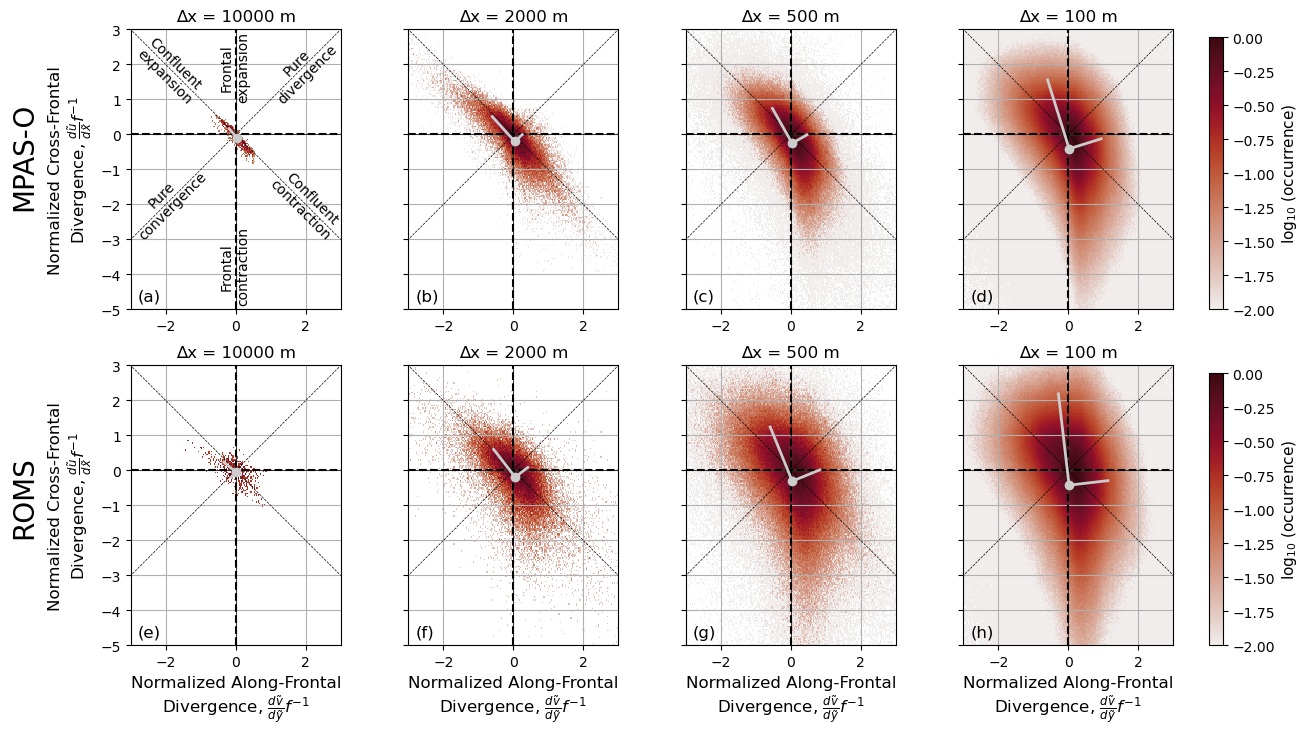

In [68]:
fig, axs = plt.subplots(2, 4, figsize=(14, 8))
# fig = plt.figure(figsize=(14, 8))

subsel = [0, 2, 4, 6, 0, 2, 4, 6] # Select 4 resolutions for plots
raxi = 0
sublab = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

gs1 = gridspec.GridSpec(2, 4)
gs1.update(wspace=0.1)

for axi in range(len(subsel)):
    if xvec[axi]==0: # MPAS-O plots
        ax = plt.subplot(gs1[axi])
        plt.axis('on')
        h = mhpca[subsel[axi]]
        xo = mxos[subsel[axi]]
        yo = myos[subsel[axi]]
        e = mes[subsel[axi]]
        v = mvs[subsel[axi]]
    elif xvec[axi]==1: # ROMS plots
        ax = plt.subplot(gs1[axi])
        plt.axis('on')        
        h = rhpca[subsel[axi]]
        xo = rxos[subsel[axi]]
        yo = ryos[subsel[axi]]
        e = res[subsel[axi]]
        v = rvs[subsel[axi]]
        raxi+=1
        
    pc = ax.pcolormesh(xbin_coords, ybin_coords, np.log10(h/np.max(h)), cmap=cmo.amp)
    pc.set_clim(-2, 0)
    ax.set_aspect(1.0)
    
    ax.set_xlim([-3, 3])
    ax.set_ylim([-5, 3])

    ax.grid()
    
    ax.plot([-3, 3], [0, 0], '-k', lw=0.5)
    ax.plot([0, 0], [-5, 3], '-k', lw=0.5)
    ax.plot([0, 3], [0, 3], '--k', lw=0.5)
    ax.plot([0, -3], [0, 3], '--k', lw=0.5)
    ax.plot([0, 3], [0, -3], '--k', lw=0.5)
    ax.plot([0, -3], [0, -3], '--k', lw=0.5)
    
    ax.axvline(color="k", linestyle='--', linewidth=1.5)
    ax.axhline(color="k", linestyle='--', linewidth=1.5)
    ax.plot(xo, yo, 'o', color='0.8')
    ax.plot([xo, xo+np.sqrt(e[0])*v[1, 0]], [yo, yo+np.sqrt(e[0])*v[0, 0]], '-', color='0.8', lw=2)
    ax.plot([xo, xo+np.sqrt(e[1])*v[1, 1]], [yo, yo+np.sqrt(e[1])*v[0, 1]], '-', color='0.8', lw=2)

    # Label the relevant lines for interpretability
    if xvec[axi]==0 and yvec[axi]==0:
        ax.text(-2.9, 0.9, 'Confluent\nexpansion', rotation=-45, fontsize=10)
        ax.text(2.0, -3.0, 'Confluent\ncontraction', rotation=-45, fontsize=10, horizontalalignment='center')
        ax.text(1.9, 0.89, 'Pure\ndivergence', rotation=45, fontsize=10, horizontalalignment='center')
        ax.text(-1.95, -3.0, 'Pure\nconvergence', rotation=45, fontsize=10, horizontalalignment='center')
        ax.text(-0.02, -4.8, 'Frontal\ncontraction', rotation=90, fontsize=10, horizontalalignment='center')
        ax.text(-0.02, 1.0, 'Frontal\nexpansion', rotation=90, fontsize=10, horizontalalignment='center')        
    
    ax.set_title('∆x = %d m' % dxs[subsel[axi]])  
    ax.text(-2.8, -4.75, '%s' % sublab[axi], size=12)
    
    if xvec[axi]==0:
        ax.set_xlabel('')
    elif xvec[axi]==1:
        ttext = 'Normalized Along-Frontal' + '\nDivergence, ' + r'$\frac{d\~v}{d\~y}f^{-1}$'
        ax.set_xlabel(ttext,fontsize=12)
    
    if axi % 4 > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    else:
        ttext = 'Normalized Cross-Frontal' + '\nDivergence, ' + r'$\frac{d\~u}{d\~x}f^{-1}$'
        ax.set_ylabel(ttext,fontsize=12)
        if xvec[axi]==0:
            ax.text(-6.45, -2.0, 'MPAS-O', size=20, rotation=90)
        elif xvec[axi]==1:
            ax.text(-6.45, -1.75, 'ROMS', size=20, rotation=90)

fig.subplots_adjust(wspace=0)

cax = fig.add_axes([0.91, 0.11, 0.01, 0.34])
cbar = plt.colorbar(pc, cax=cax, aspect=0.2)
cbar.ax.set_ylabel('log$_{10}$ (occurrence)', fontsize=11)

cax = fig.add_axes([0.91, 0.53, 0.01, 0.34])
cbar = plt.colorbar(pc, cax=cax, aspect=0.2)
cbar.ax.set_ylabel('log$_{10}$ (occurrence)', fontsize=11)

plt.show()
